In [1]:
# Importing necessary libraries
# TODO:clean this
import pandas as pd
import numpy as np
import os
pd.options.mode.chained_assignment = None 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import cv2
import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy

2024-07-11 21:58:38.878309: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 21:58:38.919154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 21:58:39.587869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#df for 64 embeddings
df = pd.read_pickle('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_mood_embeddings.pkl')

## Training the model

In [3]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [4]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

In [5]:
data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
    filename_npy = str(filename[:-4]) + '.npy'
    file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
    img = np.load(file_path)
    data.append(add_gauss_noise(img))

    # To ensure that the files are getting loaded in the correct order
    if i < 10 :
        print(filename)
    i = i+1

data = np.array(data)

american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-291-320.mp3
lvx_nova-lvx_nova-01-contimune-233-262.mp3
lvx_nova-lvx_nova-01-contimune-291-320.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-0-29.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-349-378.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-784-813.mp3
ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-59-88.mp3
ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-117-146.mp3
ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-175-204.mp3
philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-88-117.mp3


In [6]:
# data = np.load('data/magnatagatune/saved_df_data/data_array.npy')
# data = np.load('/home/mendu/Thesis/data/magnatagatune/saved_df_data/data_array.npy')

In [7]:
# Caption Embeddings
embeddings = df['caption_embedding']

In [8]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(5997, 128, 1255)

In [9]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split data into training and validation sets
X_train_spec, X_val_spec, X_train_embed, X_val_embed, y_train, y_val = train_test_split(data, embeddings, pd.get_dummies(df['tags']), test_size=0.1, random_state=42)

In [10]:
# Now, convert this array of arrays into a proper 2D NumPy array
X_train_embed_array = np.stack(X_train_embed, axis=0)

# Check the new shape to ensure it's (450, 64)
print("Shape after conversion:", X_train_embed_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
X_train_embed_tensor = tf.convert_to_tensor(X_train_embed_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", X_train_embed_tensor.shape)

Shape after conversion: (5397, 64)
Tensor shape: (5397, 64)


2024-07-11 21:59:05.840632: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
# Convert the 1D array of arrays into a proper 2D NumPy array
X_val_embed_array = np.stack(X_val_embed, axis=0)

# Check the new shape to ensure it's in the correct format
print("Shape after conversion:", X_val_embed_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
X_val_embed_tensor = tf.convert_to_tensor(X_val_embed_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", X_val_embed_tensor.shape)

Shape after conversion: (600, 64)
Tensor shape: (600, 64)


In [12]:
# Convert training data to tensors
X_train_spec = tf.convert_to_tensor(X_train_spec, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Convert validation data to tensors
X_val_spec = tf.convert_to_tensor(X_val_spec, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [13]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train_spec)

In [14]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

7

In [15]:
data.shape

(5997, 128, 1255, 1)

In [16]:
def create_model(num_classes, l1_reg=0.01, l2_reg=0.001, alpha=0.0):
    class ModelSubClassing(keras.Model):
        def __init__(self, num_classes, l1_reg=0.01, l2_reg=0.001, alpha = 0):
            super().__init__()
            
            # Define L1 and L2 regularizer
            self.l1_l2_regularizer = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
            # self.l2_regularizer = regularizers.l2(l2_reg)
            
            # Define alpha the loss regulator
            self.alpha = alpha
            
            # number of classes
            self.num_classes = num_classes
            
            # Initialize layers as None
            self.conv1 = None
            self.max1 = None
            self.bn1 = None
            self.conv2 = None
            self.bn2 = None
            self.max2 = None
            self.drop1 = None
            self.conv3 = None
            self.bn3 = None
            self.max3 = None
            self.drop2 = None
            self.flatten = None
            self.dense128 = None
            self.dense128_activation = None
            self.dense128_do = None
            self.dense64 = None
            self.dense64_activation = None
            self.dense_out = None
            
            self.loss_tracker = keras.metrics.Mean(name="loss")
            self.accuracy = keras.metrics.CategoricalAccuracy(name="accuracy")

        def build(self, input_shape):
            # Create layers
            self.conv1 = Conv2D(32, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
            self.max1  = MaxPooling2D(3)
            self.bn1   = BatchNormalization(momentum=0.9)

            self.conv2 = Conv2D(64, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
            self.bn2   = BatchNormalization(momentum=0.9)
            self.max2  = MaxPooling2D(3)
            self.drop1 = Dropout(0.3)

            self.conv3 = Conv2D(128, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
            self.bn3   = BatchNormalization(momentum=0.9)
            self.max3  = MaxPooling2D(3)
            self.drop2 = Dropout(0.3)

            self.flatten = Flatten()
            self.dense128 = Dense(128)
            self.dense128_activation = Activation('relu')
            self.dense128_do = Dropout(0.3)
            self.dense64 = Dense(64)
            self.dense64_activation = Activation('relu')
            self.dense_out = Dense(self.num_classes, activation="softmax")
            
            super().build(input_shape)

        def call(self, inputs, training=None):
            # Unpack the inputs
            mel_spectrogram = inputs[0]

            # Forward pass: block 1
            x = self.conv1(mel_spectrogram)
            x = self.max1(x)
            x = self.bn1(x, training=training)

            # Forward pass: block 2
            x = self.conv2(x)
            x = self.bn2(x, training=training)
            x = self.max2(x)
            x = self.drop1(x, training=training)

            # Forward pass: block 3
            x = self.conv3(x)
            x = self.bn3(x, training=training)
            x = self.max3(x)
            x = self.drop2(x, training=training)

            # Flatten and dense layers
            x = self.flatten(x)
            x_dense128 = self.dense128(x)
            x_dense128_act = self.dense128_activation(x_dense128)
            x_dense128_act = self.dense128_do(x_dense128_act)
            x_dense64 = self.dense64(x_dense128_act)
            x_dense64_act = self.dense64_activation(x_dense64)
            y_hat = self.dense_out(x_dense64_act)
            
            return y_hat, x_dense64


        def train_step(self, data):
            # Unpack the data
            (mel_spectrogram, caption_embedding), y = data

            with tf.GradientTape() as tape: 
            #here we get the gradients of the trainable weights with this loss
                y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=True)  # Forward pass
                # Compute the standard loss value
                loss = self.compiled_loss(y, y_pred)
                custom_loss = self.custom_loss(caption_embedding, x_dense64)
                total_loss = (1 - self.alpha) * loss + self.alpha * custom_loss

            # Compute gradients
            # trainable_vars = self.trainable_variables
            # gradients = tape.gradient(total_loss, trainable_vars)
            gradients = tape.gradient(total_loss, self.trainable_variables)

            # Update weights
            # self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            # Update the loss metric and any additional metrics
            self.loss_tracker.update_state(total_loss) #this is different
            
            #old
            # for metric in self.metrics:
            #     metric.update_state(y, y_pred)

            # return {
            #     "loss": self.loss_tracker.result(),
            #     # "mae": self.mae_metric.result(),
            #     **{m.name: m.result() for m in self.metrics},
            # }
            
            #new
            self.accuracy.update_state(y, y_pred)

            return {
                "loss": self.loss_tracker.result(),
                "accuracy": self.accuracy.result(),
                "crossentropy_loss": loss,
                "embedding_loss": custom_loss,
                "total_loss": total_loss
            }

            
        def test_step(self, data):
            # Unpack the data
            (mel_spectrogram, caption_embedding), y = data

            
            y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=False)  # Forward pass
            # Compute the standard loss value
            loss = self.compiled_loss(y, y_pred)
            custom_loss = self.custom_loss(caption_embedding, x_dense64)
            total_loss = (1 - self.alpha) * loss + self.alpha * custom_loss

            # Update the loss metric and any additional metrics
            self.loss_tracker.update_state(total_loss)
            
            #old
            # for metric in self.metrics:
            #     metric.update_state(y, y_pred)

            # return {
            #     "loss": self.loss_tracker.result(),
            #     # "mae": self.mae_metric.result(),
            #     **{m.name: m.result() for m in self.metrics},
            # }
            
            #new
            self.accuracy.update_state(y, y_pred)

            return {
                "loss": self.loss_tracker.result(),
                "accuracy": self.accuracy.result(),
                "crossentropy_loss": loss,
                "embedding_loss": custom_loss,
                "total_loss": total_loss
            }
            
        # Add a custom loss method in the model
        def custom_loss(self, caption_embedding, x_dense64):
            return tf.reduce_mean(tf.square(caption_embedding - x_dense64))

        #new
        @property
        def metrics(self):
            # List all metrics to be reset after each epoch
            return [self.loss_tracker, self.accuracy]
        
    # Creating the class object
    model = ModelSubClassing(num_classes)

    # Compile the model
    adam_opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
# Define hyperparameters for grid search
param_grid = {
    # 'l1_reg': [0.01, 0.001],
    # 'l2_reg': [0.01, 0.001],
    'alpha': [0.0, 0.001, 0.0001]
}

# Define an empty dictionary to store history objects
history_dict = {}
results_dict = {}

# Perform grid search
best_accuracy = 0
best_params = None
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    
    model = create_model(num_classes, **params)
    
    rlronp = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
    early_stopper = EarlyStopping(monitor='val_loss', patience=18, verbose=1, restore_best_weights=True)
    history = model.fit(
        (X_train_spec, X_train_embed_tensor),
        y_train,
        epochs= 100,
        batch_size=32,
        validation_data=((X_val_spec, X_val_embed_tensor), y_val),
        callbacks=[early_stopper, rlronp]
    )
    
    # Save the history keyed by the parameter tuple for later reference
    history_dict[tuple(params.values())] = history.history
    
    # Evaluate manually
    train_loss, train_accuracy = model.evaluate((X_train_spec, X_train_embed_tensor), y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate((X_val_spec, X_val_embed_tensor), y_val, verbose=0)
    
    results_dict[tuple(params.values())] = {
    'train_accuracy': train_accuracy,
    'train_loss': train_loss,
    'val_accuracy': val_accuracy,
    'val_loss': val_loss
    }
    
    print(f"Training accuracy: {train_accuracy}, Validation accuracy: {val_accuracy} for params: {params}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        
    

print(f"Best params: {best_params} with validation accuracy: {best_accuracy}")



Testing params: {'alpha': 0.0}
Epoch 1/100


/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:612: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - accuracy: 0.3891 - crossentropy_loss: 28.5726 - embedding_loss: 10618.6172 - loss: 30.4544 - total_loss: 28.5726 - val_accuracy: 0.5300 - val_loss: 24.9622 - learning_rate: 1.0000e-04
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 328ms/step - accuracy: 0.5175 - crossentropy_loss: 21.8095 - embedding_loss: 10546.6484 - loss: 23.4164 - total_loss: 21.8095 - val_accuracy: 0.6117 - val_loss: 18.4774 - learning_rate: 1.0000e-04
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 334ms/step - accuracy: 0.5568 - crossentropy_loss: 15.9025 - embedding_loss: 10558.2012 - loss: 17.2111 - total_loss: 15.9025 - val_accuracy: 0.6117 - val_loss: 13.2447 - learning_rate: 1.0000e-04
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 327ms/step - accuracy: 0.5732 - crossentropy_loss: 11.2982 - embedding_loss: 10557.1963 - loss: 12.2672 - total_loss: 11.2982 - val_accuracy: 0.6117 - val_loss: 9.3860 - learning_rate: 1.0000e-04
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 

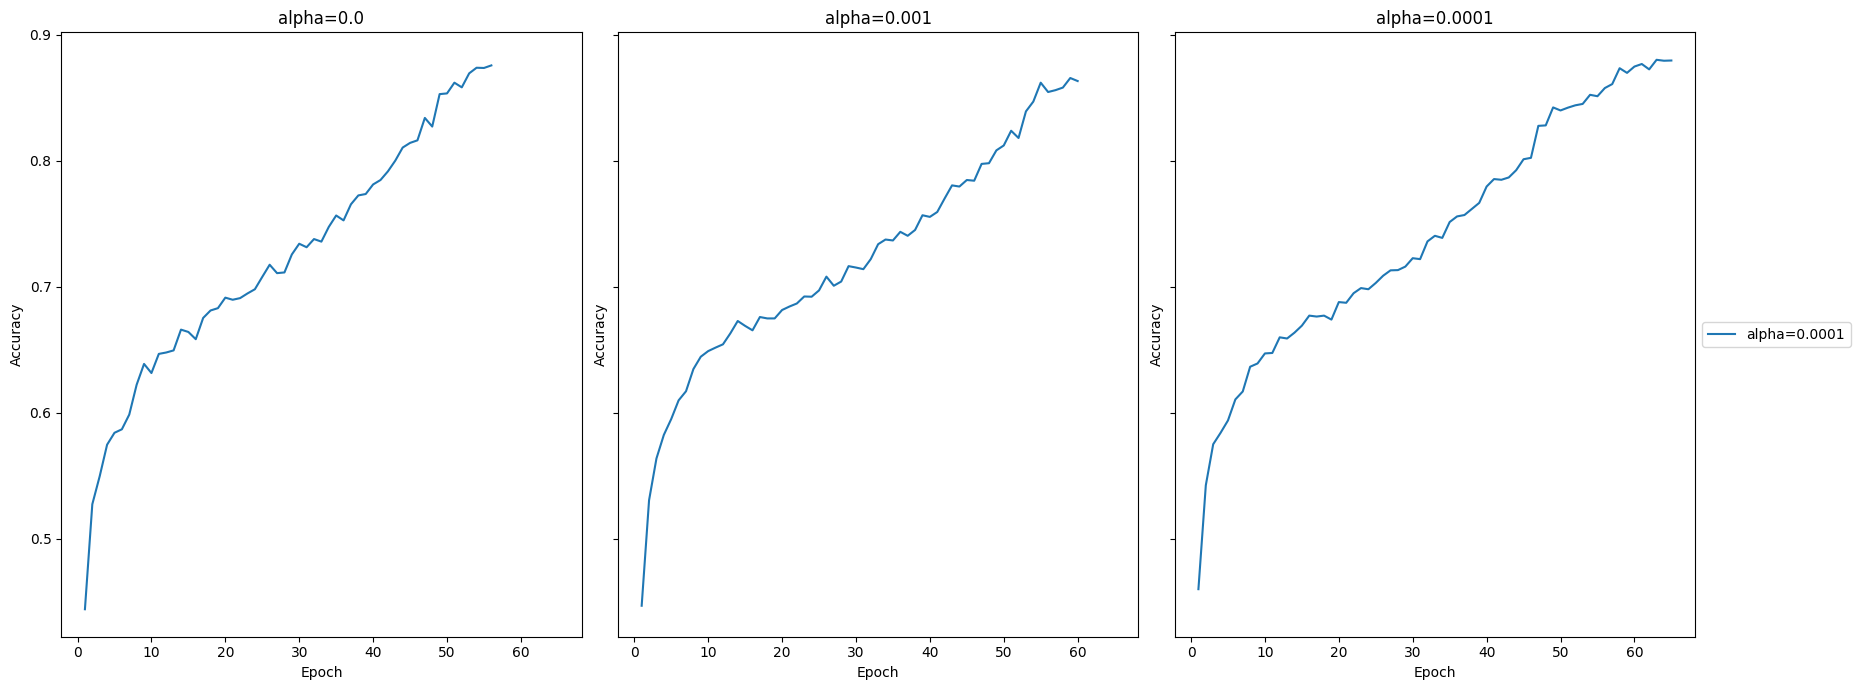

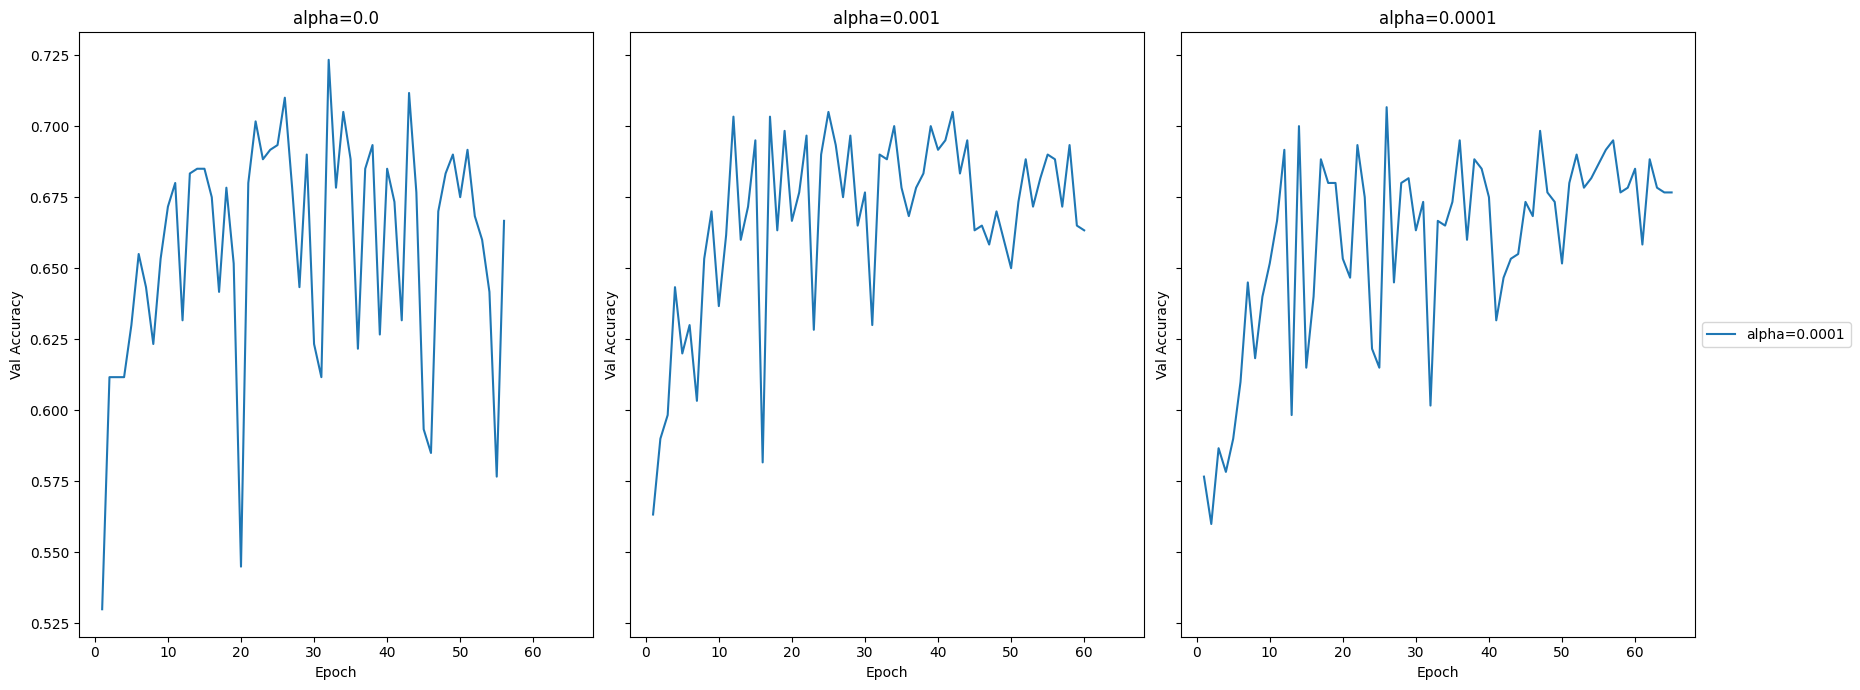

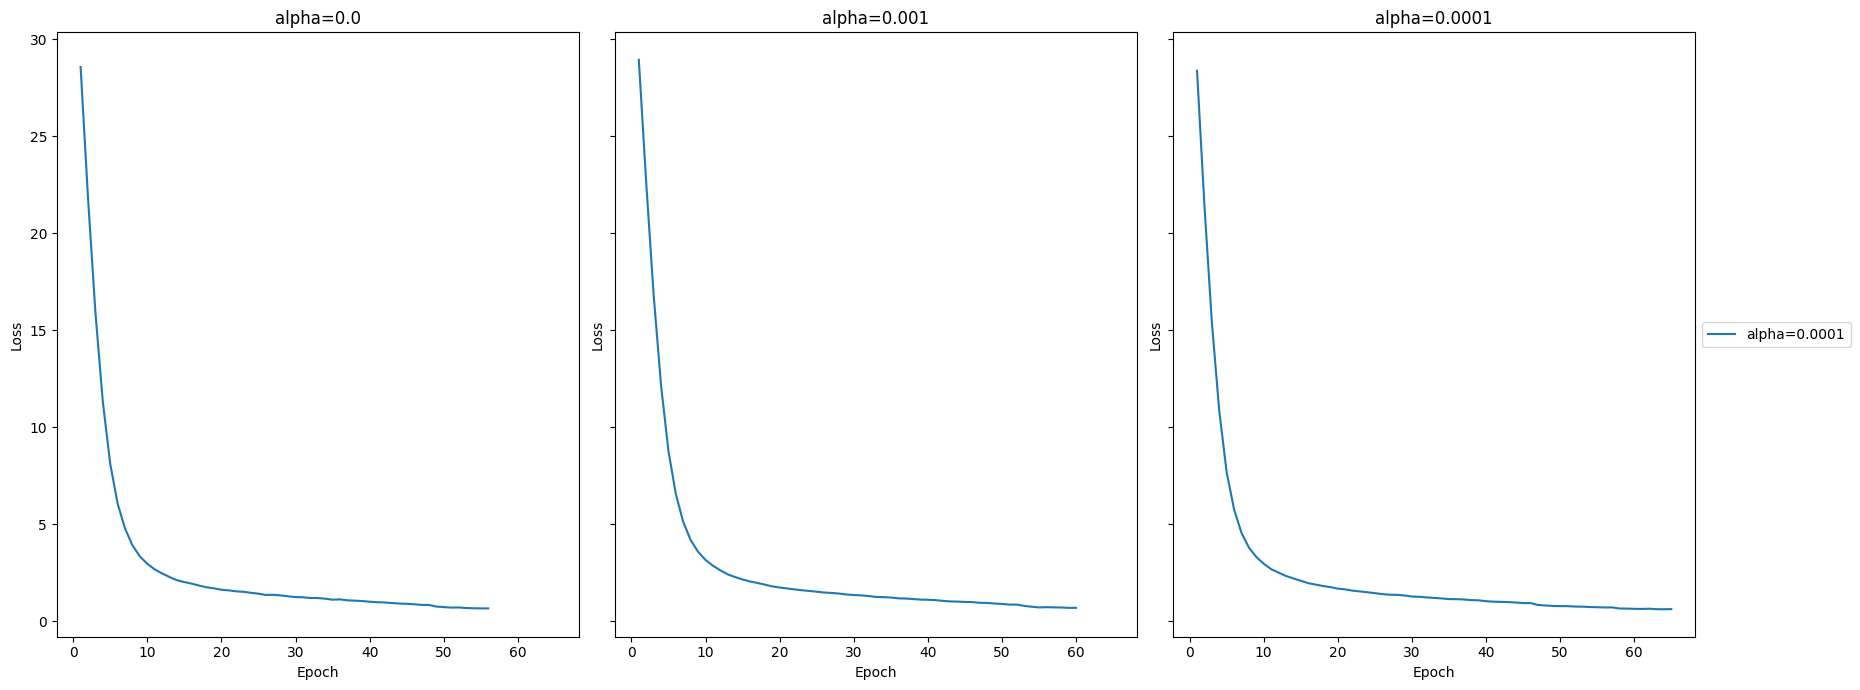

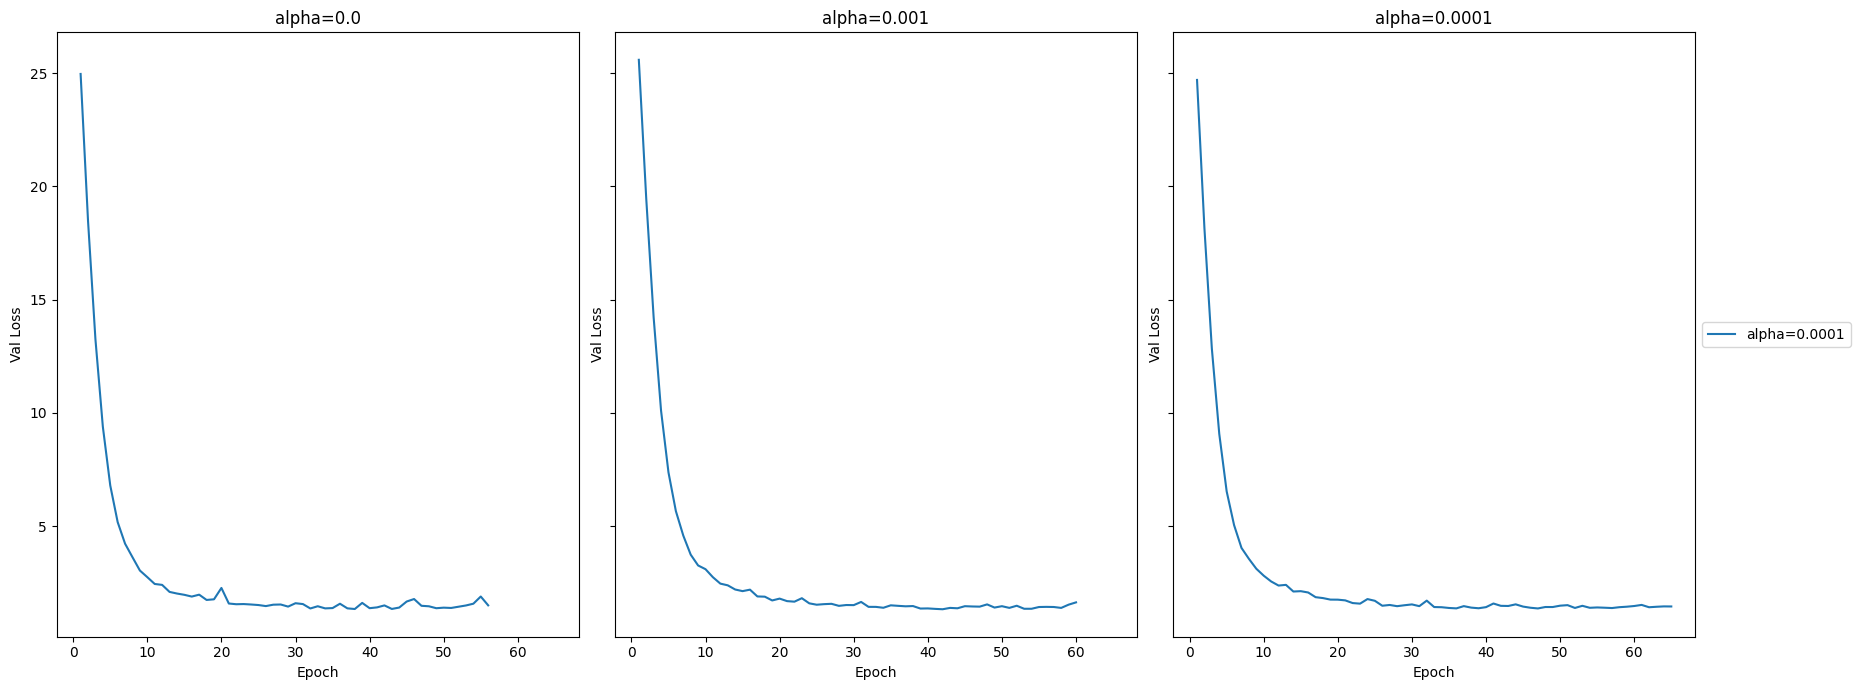

In [18]:
# Define number of subplots needed
num_combinations = len(history_dict)
rows = cols = int(num_combinations ** 0.5)
cols = rows if rows * rows == num_combinations else rows + 1

# If the square root of combinations does not give an integer grid, slightly increase the number of columns
if rows * cols < num_combinations:
    cols += 1

# Create subplots for each metric
fig_size = (20,7)
fig_acc, axes_acc = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True)
fig_val_acc, axes_val_acc = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True)
fig_loss, axes_loss = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True)
fig_val_loss, axes_val_loss = plt.subplots(rows, cols, figsize=fig_size, sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes_acc_flat = axes_acc.flatten()
axes_val_acc_flat = axes_val_acc.flatten()
axes_loss_flat = axes_loss.flatten()
axes_val_loss_flat = axes_val_loss.flatten()

# Loop through each combination's history and plot it in a dedicated subplot
for idx, (parameter_combination, history) in enumerate(history_dict.items()):
    num_epochs = len(history['accuracy'])
    epochs = range(1, num_epochs + 1)

    # Parameters string for legend label
    # params_label = f"alpha={parameter_combination[0]}, l1 = {parameter_combination[1]}, l2 = {parameter_combination[2]}"
    params_label = f"alpha={parameter_combination[0]}"
    
    # Plot Training accuracy for this combination
    axes_acc_flat[idx].plot(epochs, history['accuracy'], label=params_label)
    axes_acc_flat[idx].set_title(params_label)
    axes_acc_flat[idx].set_xlabel('Epoch')
    axes_acc_flat[idx].set_ylabel('Accuracy')

    # Plot Validation accuracy for this combination
    axes_val_acc_flat[idx].plot(epochs, history['val_accuracy'], label=params_label)
    axes_val_acc_flat[idx].set_title(params_label)
    axes_val_acc_flat[idx].set_xlabel('Epoch')
    axes_val_acc_flat[idx].set_ylabel('Val Accuracy')

    # Plot Training loss for this combination
    axes_loss_flat[idx].plot(epochs, history['loss'], label=params_label)
    axes_loss_flat[idx].set_title(params_label)
    axes_loss_flat[idx].set_xlabel('Epoch')
    axes_loss_flat[idx].set_ylabel('Loss')

    # Plot Validation loss for this combination
    axes_val_loss_flat[idx].plot(epochs, history['val_loss'], label=params_label)
    axes_val_loss_flat[idx].set_title(params_label)
    axes_val_loss_flat[idx].set_xlabel('Epoch')
    axes_val_loss_flat[idx].set_ylabel('Val Loss')

# After adding all the plots to the subplots, adjust the layout and add the legend outside the last axis in each figure
for axes, fig in [(axes_acc_flat, fig_acc), 
                  (axes_val_acc_flat, fig_val_acc), 
                  (axes_loss_flat, fig_loss), 
                  (axes_val_loss_flat, fig_val_loss)]:
    # Put a legend to the right of the last subplot
    axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Hide any unused axes if the number of combinations isn't a perfect square
    for ax in axes[num_combinations:]:
        ax.set_visible(False)

    fig.tight_layout()
    fig.subplots_adjust(right=0.85)  # Adjust subplot params so the legend outside fits
    fig.show()

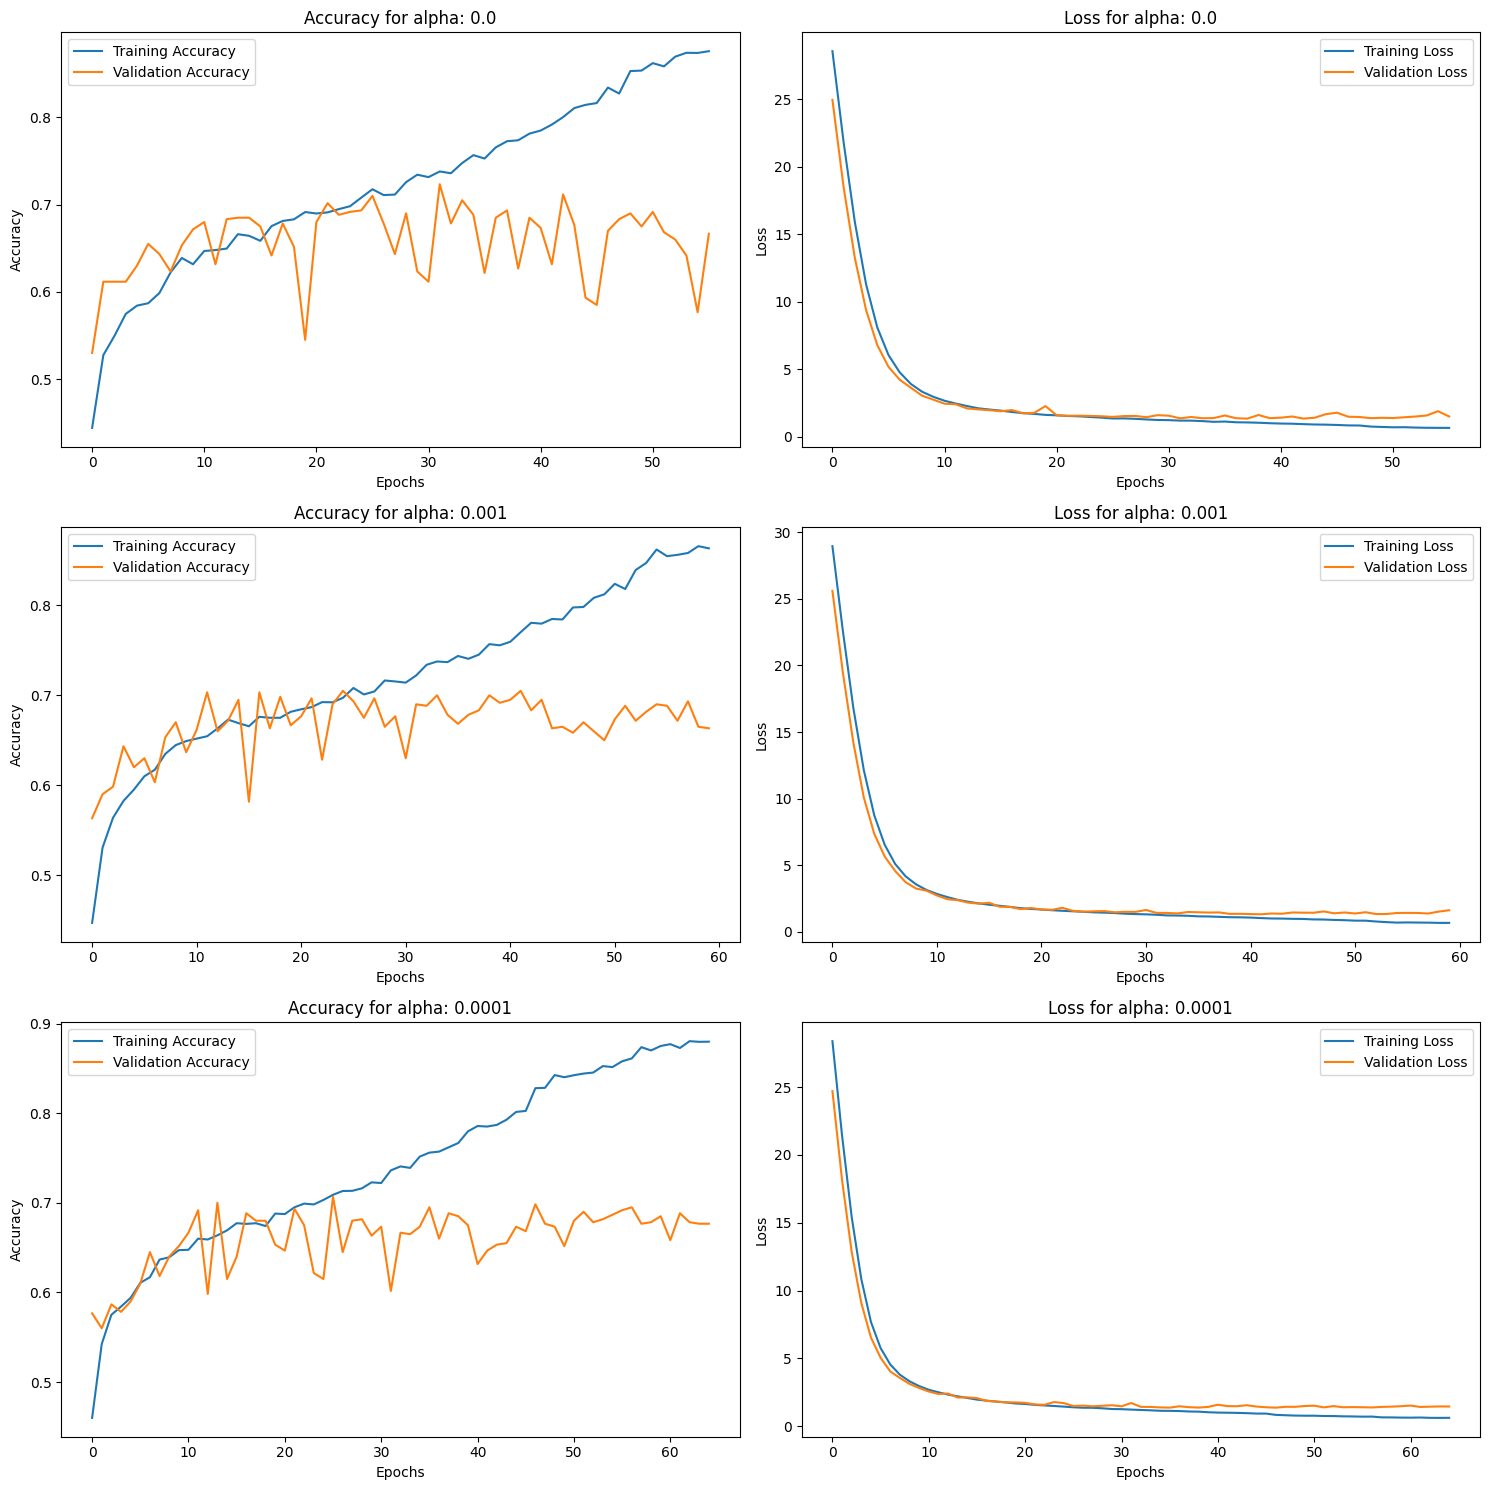

In [19]:
# Plotting
def plot_history(history_dict):
    num_combinations = len(history_dict)
    fig, axs = plt.subplots(num_combinations, 2, figsize=(15, 5 * num_combinations))
    
    if num_combinations == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i, (params, history) in enumerate(history_dict.items()):
        # param_str = f"alpha: {params[0]}, l1 = {params[1]}, l2 = {params[2]}"
        param_str = f"alpha: {params[0]}"
        
        # Plot accuracy
        axs[i, 0].plot(history['accuracy'], label='Training Accuracy')
        axs[i, 0].plot(history['val_accuracy'], label='Validation Accuracy')
        axs[i, 0].set_title(f'Accuracy for {param_str}')
        axs[i, 0].set_xlabel('Epochs')
        axs[i, 0].set_ylabel('Accuracy')
        axs[i, 0].legend()
        
        # Plot loss
        axs[i, 1].plot(history['loss'], label='Training Loss')
        axs[i, 1].plot(history['val_loss'], label='Validation Loss')
        axs[i, 1].set_title(f'Loss for {param_str}')
        axs[i, 1].set_xlabel('Epochs')
        axs[i, 1].set_ylabel('Loss')
        axs[i, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_history(history_dict)

In [20]:
pd.DataFrame(results_dict)

,0.0000,0.0010,0.0001
train_accuracy,0.831573,0.808783,0.884010
train_loss,0.907512,0.932203,0.685487
val_accuracy,0.693333,0.705000,0.698333
val_loss,1.338063,1.327599,1.363115


In [21]:
import pickle

with open('/home/mendu/Thesis/data/magnatagatune/history_dict_gridsearch4.pkl', 'wb') as f:
    pickle.dump(history_dict, f)

In [22]:
history_dict

{(0.0,): {'accuracy': [0.4441356360912323,
   0.5275152921676636,
   0.5497498512268066,
   0.5747637748718262,
   0.5842134356498718,
   0.5869928002357483,
   0.5986659526824951,
   0.6223828196525574,
   0.6388734579086304,
   0.6316472291946411,
   0.6468408107757568,
   0.6479525566101074,
   0.6496201753616333,
   0.6661108136177063,
   0.6642579436302185,
   0.6585139632225037,
   0.67537522315979,
   0.6813044548034668,
   0.6831573247909546,
   0.6914952993392944,
   0.6898276805877686,
   0.691124677658081,
   0.6948304772377014,
   0.6981656551361084,
   0.7079859375953674,
   0.7176209092140198,
   0.7109505534172058,
   0.7115063667297363,
   0.7257735729217529,
   0.7342968583106995,
   0.731517493724823,
   0.738002598285675,
   0.7359644174575806,
   0.7476375699043274,
   0.7567166686058044,
   0.7528256177902222,
   0.7656105160713196,
   0.7726514935493469,
   0.7737631797790527,
   0.7813600301742554,
   0.784880518913269,
   0.7917361259460449,
   0.800259411334991

In [23]:
history['accuracy']

[0.46007040143013,
 0.5425236225128174,
 0.5751343369483948,
 0.5842134356498718,
 0.5940337181091309,
 0.6107096672058105,
 0.6170094609260559,
 0.6366499662399292,
 0.639244019985199,
 0.6472114324569702,
 0.6475819945335388,
 0.6599962711334229,
 0.659069836139679,
 0.6637020707130432,
 0.6692606806755066,
 0.6772280931472778,
 0.6764869093894958,
 0.6772280931472778,
 0.6740781664848328,
 0.6879748106002808,
 0.6874189376831055,
 0.6950157284736633,
 0.6990920901298523,
 0.6981656551361084,
 0.7031684517860413,
 0.7089123725891113,
 0.7131739854812622,
 0.7133592963218689,
 0.7161386013031006,
 0.7228089570999146,
 0.7220678329467773,
 0.7361497282981873,
 0.7405966520309448,
 0.738929033279419,
 0.7515286207199097,
 0.7559755444526672,
 0.7570872902870178,
 0.761904776096344,
 0.7667222619056702,
 0.7796924114227295,
 0.7856216430664062,
 0.785065770149231,
 0.7869186401367188,
 0.7926625609397888,
 0.801371157169342,
 0.8024828433990479,
 0.827867329120636,
 0.8282378911972046,
 

In [24]:
# early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# history = model.fit(
#     (X_train_spec, X_train_embed_tensor),
#     y_train,
#     epochs=100,
#     batch_size=32,
#     validation_data=((X_val_spec, X_val_embed_tensor), y_val),
#     callbacks = [early_stopper]
# )

In [25]:
# # First, let's gather the maximum epoch number reached among all histories
# max_epoch = max([len(history['accuracy']) for history in history_dict.values()])

# # Now, for plotting purposes, let's create four separate figures
# fig_acc, ax_acc = plt.subplots()
# fig_val_acc, ax_val_acc = plt.subplots()
# fig_loss, ax_loss = plt.subplots()
# fig_val_loss, ax_val_loss = plt.subplots()

# # Now we loop through each combination's history and plot it appropriately
# for parameter_combination, history in history_dict.items():
#     num_epochs = len(history['accuracy'])
#     epochs = range(1, num_epochs + 1)

#     # Parameters string for legend label
#     params_label = f'l1_reg={parameter_combination[0]}_l2_reg={parameter_combination[1]}'

#     # Training accuracy for this combination
#     ax_acc.plot(epochs, history['accuracy'], label=params_label)

#     # Validation accuracy for this combination
#     ax_val_acc.plot(epochs, history['val_accuracy'], label=params_label)
    
#     # Training loss for this combination
#     ax_loss.plot(epochs, history['loss'], label=params_label)
    
#     # Validation loss for this combination
#     ax_val_loss.plot(epochs, history['val_loss'], label=params_label)

# # After plotting all combinations on separate figures, let's show the plots with legends
# ax_acc.set_title('Training Accuracy for all combinations')
# ax_acc.set_xlabel('Epoch')
# ax_acc.set_ylabel('Accuracy')
# ax_acc.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ax_val_acc.set_title('Validation Accuracy for all combinations')
# ax_val_acc.set_xlabel('Epoch')
# ax_val_acc.set_ylabel('Accuracy')
# ax_val_acc.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ax_loss.set_title('Training Loss for all combinations')
# ax_loss.set_xlabel('Epoch')
# ax_loss.set_ylabel('Loss')
# ax_loss.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ax_val_loss.set_title('Validation Loss for all combinations')
# ax_val_loss.set_xlabel('Epoch')
# ax_val_loss.set_ylabel('Loss')
# ax_val_loss.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# fig_acc.show()
# fig_val_acc.show()
# fig_loss.show()
# fig_val_loss.show()

In [26]:
# # Plot a graph for training and validation loss
# plt.figure(figsize=(10, 5)) # Optionally specify the figure size
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot a graph for training and validation accuracy
# plt.figure(figsize=(10, 5)) # Optionally specify the figure size
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoche')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [27]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Get predictions
# predictions = model.predict((X_val_spec, X_val_embed_tensor))
# predicted_labels = np.argmax(predictions[0], axis=1)  # Converting probabilities to class labels
# ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# # Reshape predicted_labels and ground_truth to be 1D arrays
# predicted_labels = np.reshape(predicted_labels, (-1,))
# ground_truth = np.reshape(ground_truth, (-1,))

# # Define class labels
# class_labels = ['classical', 'country', 'electronic', 'indian',
#                 'new age', 'opera', 'pop', 'rock']

# predicted_labels = [class_labels[i] for i in predicted_labels]
# ground_truth = [class_labels[i] for i in ground_truth]

# # Create a table with prediction and ground truth
# comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})
# # Get unique class labels
# unique_labels = sorted(comparison_table['Ground Truth'].unique())

# # Create confusion matrix
# conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'], labels=unique_labels)

# # Convert confusion matrix to DataFrame for better visualization
# conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
# plt.xlabel('Predicted Class')
# plt.ylabel('Ground Truth')
# plt.title('Confusion Matrix')
# plt.show()


In [28]:
# # First, let's gather the maximum epoch number reached among all histories
# max_epoch = max([len(history['accuracy']) for history in history_dict.values()])

# # Now, for plotting purposes, let's create four separate figures
# fig_acc, ax_acc = plt.subplots()
# fig_val_acc, ax_val_acc = plt.subplots()
# fig_loss, ax_loss = plt.subplots()
# fig_val_loss, ax_val_loss = plt.subplots()

# # Now we loop through each combination's history and plot it appropriately
# for parameter_combination, history in history_dict.items():
#     num_epochs = len(history['accuracy'])
#     epochs = range(1, num_epochs + 1)

#     # Parameters string for legend label
#     params_label = f'l1_reg={parameter_combination[0]}_l2_reg={parameter_combination[1]}'

#     # Training accuracy for this combination
#     ax_acc.plot(epochs, history['accuracy'], label=params_label)

#     # Validation accuracy for this combination
#     ax_val_acc.plot(epochs, history['val_accuracy'], label=params_label)
    
#     # Training loss for this combination
#     ax_loss.plot(epochs, history['loss'], label=params_label)
    
#     # Validation loss for this combination
#     ax_val_loss.plot(epochs, history['val_loss'], label=params_label)

# # After plotting all combinations on separate figures, let's show the plots with legends
# ax_acc.set_title('Training Accuracy for all combinations')
# ax_acc.set_xlabel('Epoch')
# ax_acc.set_ylabel('Accuracy')
# ax_acc.legend()

# ax_val_acc.set_title('Validation Accuracy for all combinations')
# ax_val_acc.set_xlabel('Epoch')
# ax_val_acc.set_ylabel('Accuracy')
# ax_val_acc.legend()

# ax_loss.set_title('Training Loss for all combinations')
# ax_loss.set_xlabel('Epoch')
# ax_loss.set_ylabel('Loss')
# ax_loss.legend()

# ax_val_loss.set_title('Validation Loss for all combinations')
# ax_val_loss.set_xlabel('Epoch')
# ax_val_loss.set_ylabel('Loss')
# ax_val_loss.legend()

# fig_acc.show()
# fig_val_acc.show()
# fig_loss.show()
# fig_val_loss.show()